In [1]:
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 14}
matplotlib.rc('font', **font)
from jax import grad, random, jit, vmap
from functools import partial
import jax.example_libraries.optimizers as optimizers
import pickle
key = random.PRNGKey(0)
import pandas as pd
from jax.flatten_util import ravel_pytree

from utils import uniaxial_relax, sigma_split_vmap, sigma_neoHook_vmap, init_params_nobias, init_params_positivebias, dPhi_RG_vmap, dPhi_vmap, plot45

In [2]:
# Functions for training
@partial(jit, static_argnums=(0,1,2,))
def step(loss_fn, norm, useNODE, i, opt_state, inp_batch, out_batch):
    params = get_params(opt_state)
    g = grad(loss_fn, argnums=0)(params, norm, useNODE, inp_batch, out_batch)
    return opt_update(i, g, opt_state)

def train(inp, out, norm, useNODE, opt_state, key, loss_fn, nIter = 1000, batch_size=10, print_freq=100):
    train_loss = []
    val_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        i = random.choice(subkey, inp.shape[0], shape=(batch_size,), replace = False)
        i = tuple([i])
        opt_state = step(loss_fn, norm, useNODE, it, opt_state, inp[i], out[i])
        if it % print_freq == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = loss_fn(params, norm, useNODE, inp, out)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss 

def uniaxial_relax_loss(params, norm, useNODE, inp, out):
    sigma_pr,_,_,_,_,_,_ = uniaxial_relax(params, norm, useNODE, inp[0], inp[1], dt0=0.1)
    loss = np.mean((-sigma_pr[:,0,0]-out)**2)# + (sigma_pr[:,1,1]-out[1])**2)
    return loss
uniaxial_relax_loss_vmap = vmap(uniaxial_relax_loss, in_axes=(None, None, None, 0, 0), out_axes=0)
uniaxial_relax_batch_loss = lambda params, norm, useNODE, inp, out: np.mean(uniaxial_relax_loss_vmap(params, norm, useNODE, inp, out))

def Psi_loss(params, norm, useNODE, lmb, sigma_gt):
    lm1 = lmb[:,0]
    lm2 = lmb[:,1]
    lm3 = lmb[:,2]
    sigma_pr = sigma_split_vmap(lm1, lm2, lm3, params)
    loss1 = np.mean((sigma_pr[:,0,0]-sigma_gt[:,0,0])**2) 
    loss2 = np.mean((sigma_pr[:,1,1]-sigma_gt[:,1,1])**2)
    loss3 = np.mean((sigma_pr[:,2,2]-sigma_gt[:,2,2])**2)
    loss = (loss1+loss2+loss3)/3.0
    return  loss

def Phi_loss(params, norm, useNODE, taui, dphidtaui_gt):
    tau1, tau2, tau3 = taui.transpose()
    dphidtaui_pr = dPhi_vmap([tau1, tau2, tau3], params, norm)
    loss = np.mean((dphidtaui_pr[0]-dphidtaui_gt[:,0])**2)
    loss+= np.mean((dphidtaui_pr[1]-dphidtaui_gt[:,1])**2)
    loss+= np.mean((dphidtaui_pr[2]-dphidtaui_gt[:,2])**2)
    return loss

# 1. Train Govindjee's model

In [3]:
with open('training_data/Brain/Average/C1/Comp relaxation/CR.npy','rb') as f:
    time_2, sgm_x_2 = np.load(f).T
time_2 = time_2[::2]
sgm_x_2 = sgm_x_2[::2]

load_rate = 0.02 #loading rate
lm_peak = 0.9
lm_1 = np.linspace(1.0,0.9,10)
lm_2 = np.ones_like(time_2)*lm_peak
lmb_x = np.hstack([lm_1,lm_2])

t_peak = (1.0-lm_peak)/load_rate
print('Reach peak in '+str(t_peak)+' s')
time_1 = np.linspace(0,t_peak,lm_1.shape[0])
time = np.hstack([time_1, time_2+t_peak])

sgm_x_1 = np.linspace(0,sgm_x_2[0],lm_1.shape[0])
sgm_x = np.hstack([sgm_x_1, sgm_x_2])

time = np.expand_dims(time,0)
lmb_x = np.expand_dims(lmb_x,0)
sgm_x = np.expand_dims(sgm_x,0)

inp = np.array([time, lmb_x]).transpose([1,0,2])
out = sgm_x

Reach peak in 4.999999999999999 s


In [ ]:
# Neo Hookean:
mu = 77.77*0.1
K = 1.0
RG_Psi_eq_params = [K, mu]
RG_Psi_neq_params = [K, mu]

eta_D = 1360.0
eta_V = 175000.0
RG_Phi_params = [np.log(eta_D*0.1), np.log(eta_V*0.1)]

RG_params = [RG_Psi_eq_params, RG_Psi_neq_params, RG_Phi_params]
RG_norm = (None, None, None)

with open('saved/brain_CR_RG_params0.npy', 'rb') as f: #initial guess
    RG_params = pickle.load(f)

In [ ]:
lr = 5.0e-4
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(RG_params)
RG_params, train_loss, val_loss = train(inp, out, RG_norm, False, opt_state, key, uniaxial_relax_batch_loss, nIter = 10000, batch_size=1, print_freq=1000)
    
with open('saved/brain_CR_RG_params.npy', 'wb') as f:
    pickle.dump(RG_params, f)

it 0, train loss = 4.314306e-03
it 1000, train loss = 1.962398e-03
it 2000, train loss = 1.644113e-03
it 3000, train loss = 1.411334e-03
it 4000, train loss = 8.819051e-04
it 5000, train loss = 5.615352e-04
it 6000, train loss = 4.329065e-04
it 7000, train loss = 4.815351e-04
it 8000, train loss = 3.937162e-04
it 9000, train loss = 3.991371e-04
it 10000, train loss = 3.928910e-04


[Text(0.5, 1.0, 't_peak = 5.0, loss =0.00039000000000000005')]

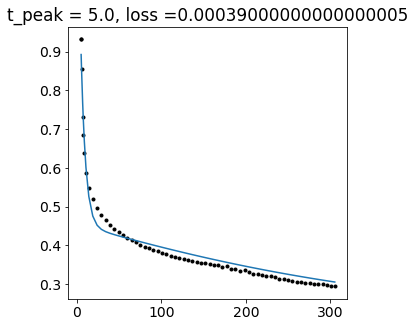

In [ ]:
fig, ax = plt.subplots(figsize=[5,5])
sigm_pr,lm1,lm2,lm3,lm1e,lm2e,lm3e = uniaxial_relax(RG_params, RG_norm, False, time[0], lmb_x[0], dt0=0.1)

ax.plot(time[0,9:],out[0,9:],'k.')
ax.plot(time[0,9:],-sigm_pr[9:,0,0])
ax.set(title='t_peak = ' + str(np.round(t_peak)) + ', loss =' + str(np.round(train_loss[-1],5)))

# 2. Train $\Psi_{EQ}$ and $\Psi_{NEQ}$

In [4]:
with open('saved/brain_CR_RG_params.npy', 'rb') as f:
    RG_params = pickle.load(f)
RG_Psi_eq_params, RG_Psi_neq_params, RG_Phi_params = RG_params

In [5]:
# Generate training data
# Inputs
lm = np.linspace(0.85,1.1,20)
lm1, lm2 = np.array(np.meshgrid(lm, lm))
lm1 = lm1.reshape(-1)
lm2 = lm2.reshape(-1)
lm3 = 1/(lm1*lm2)
lmb_1 = np.transpose(np.array([lm1, lm2, lm3]))
lmb_2 = np.transpose(np.array([lm1, lm2, lm3*0.95]))
lmb = np.vstack([lmb_1, lmb_2])

# Outputs
sigma_gt = sigma_neoHook_vmap(lmb[:,0],lmb[:,1],lmb[:,2],RG_Psi_eq_params)

## 2.1 $\Psi_{EQ}$

In [6]:
# Initialize parameters
layers = [1, 5, 5, 1]
I1_params = init_params_nobias(layers, key)
I2_params = init_params_nobias(layers, key)
J1_params = init_params_nobias(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
K, mu = RG_Psi_eq_params
Psi_eq_params = (NN_weights, alpha, Psi1_bias, Psi2_bias, K)
Psi_eq_norm = None

# Train
opt_init, opt_update, get_params = optimizers.adam(5.e-5)
opt_state = opt_init(Psi_eq_params)
Psi_eq_params, train_loss, val_loss = train(lmb, sigma_gt, Psi_eq_norm, False, opt_state, key, Psi_loss, nIter = 200000, batch_size=10, print_freq=10000)
with open('saved/brain_CR_Psi_eq_params.npy', 'wb') as f:
    pickle.dump(Psi_eq_params, f)

it 0, train loss = 1.437061e+01
it 10000, train loss = 9.984437e-03
it 20000, train loss = 5.088499e-03
it 30000, train loss = 2.850625e-03
it 40000, train loss = 1.463002e-03
it 50000, train loss = 1.069567e-03
it 60000, train loss = 9.854172e-04
it 70000, train loss = 9.168358e-04
it 80000, train loss = 8.399545e-04
it 90000, train loss = 7.633660e-04
it 100000, train loss = 6.668431e-04
it 110000, train loss = 5.733172e-04
it 120000, train loss = 4.817039e-04
it 130000, train loss = 3.815935e-04
it 140000, train loss = 3.025296e-04
it 150000, train loss = 2.278834e-04
it 160000, train loss = 1.692122e-04
it 170000, train loss = 9.514827e-05
it 180000, train loss = 4.655163e-06
it 190000, train loss = 3.249772e-06
it 200000, train loss = 2.251071e-06


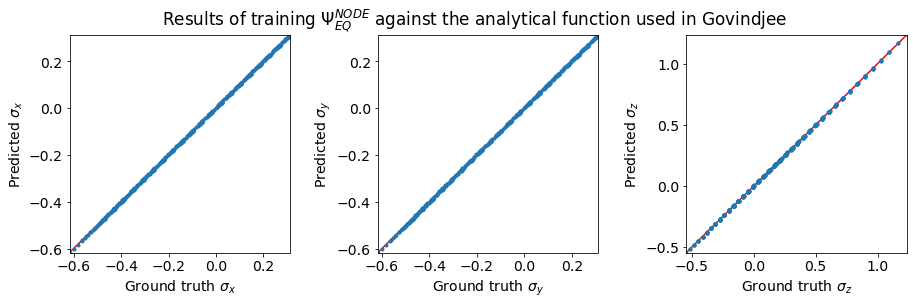

In [7]:
sigma_pr = sigma_split_vmap(lm1, lm2, lm3, Psi_eq_params)
sigma_gt = sigma_neoHook_vmap(lm1, lm2, lm3, RG_Psi_eq_params) #since I am using the same MM for both EQ and NEQ
gts = [sigma_gt[:,0,0], sigma_gt[:,1,1], sigma_gt[:,2,2]]
prs = [sigma_pr[:,0,0], sigma_pr[:,1,1], sigma_pr[:,2,2]]
labels = ['$\sigma_x$', '$\sigma_y$', '$\sigma_z$']
title = r"Results of training $\Psi_{EQ}^{NODE}$ against the analytical function used in Govindjee"
plot45(gts, prs, labels, title)

## 2.2 $\Psi_{NEQ}$

In [7]:
# Initialize parameters
layers = [1, 5, 5, 1]
I1_params = init_params_nobias(layers, key)
I2_params = init_params_nobias(layers, key)
J1_params = init_params_nobias(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
K, mu = RG_Psi_neq_params
Psi_neq_params = (NN_weights, alpha, Psi1_bias, Psi2_bias, K)
Psi_neq_norm = None

# Generate outputs
sigma_gt = sigma_neoHook_vmap(lmb[:,0],lmb[:,1],lmb[:,2],RG_Psi_neq_params)

opt_init, opt_update, get_params = optimizers.adam(5.e-5)
opt_state = opt_init(Psi_neq_params)
Psi_neq_params, train_loss, val_loss = train(lmb, sigma_gt, Psi_neq_norm, False, opt_state, key, Psi_loss, nIter = 200000, batch_size=10, print_freq=10000)

with open('saved/brain_CR_Psi_neq_params.npy', 'wb') as f:
    pickle.dump(Psi_neq_params, f)

it 0, train loss = 1.344542e+01
it 10000, train loss = 1.239488e-02
it 20000, train loss = 5.235719e-03
it 30000, train loss = 2.595088e-03
it 40000, train loss = 2.276997e-03
it 50000, train loss = 2.198868e-03
it 60000, train loss = 2.101996e-03
it 70000, train loss = 2.007050e-03
it 80000, train loss = 1.899295e-03
it 90000, train loss = 1.781531e-03
it 100000, train loss = 1.623558e-03
it 110000, train loss = 1.464285e-03
it 120000, train loss = 1.300089e-03
it 130000, train loss = 1.085954e-03
it 140000, train loss = 8.907061e-04
it 150000, train loss = 6.899940e-04
it 160000, train loss = 5.091690e-04
it 170000, train loss = 4.232738e-04
it 180000, train loss = 2.467763e-04
it 190000, train loss = 1.521980e-04
it 200000, train loss = 4.477488e-06


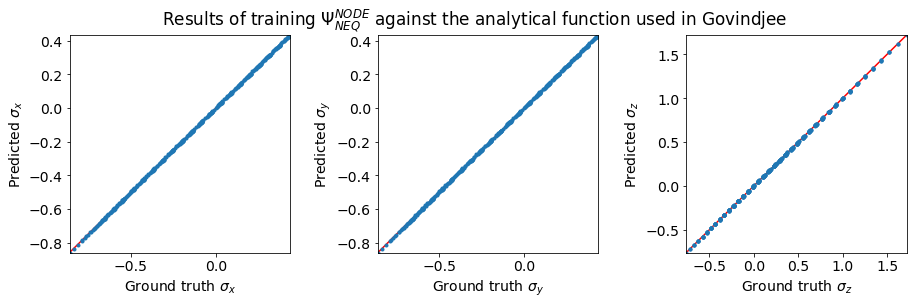

In [8]:
sigma_pr = sigma_split_vmap(lm1, lm2, lm3, Psi_neq_params)
sigma_gt = sigma_neoHook_vmap(lm1, lm2, lm3, RG_Psi_neq_params)
gts = [sigma_gt[:,0,0], sigma_gt[:,1,1], sigma_gt[:,2,2]]
prs = [sigma_pr[:,0,0], sigma_pr[:,1,1], sigma_pr[:,2,2]]
labels = ['$\sigma_x$', '$\sigma_y$', '$\sigma_z$']
title = r"Results of training $\Psi_{NEQ}^{NODE}$ against the analytical function used in Govindjee"
plot45(gts, prs, labels, title)

# 3. Train $\Phi^{NODE}$ with $\Phi^{Govindjee}$

In [3]:
with open('saved/brain_CR_RG_params.npy', 'rb') as f:
    RG_params = pickle.load(f)
RG_Psi_eq_params, RG_Psi_neq_params, RG_Phi_params = RG_params
eta_D, eta_V = RG_Phi_params

In [31]:
# Generate training data
# Input data and normalization factors
taui = onp.mgrid[-1.0:1.0:10j, -1.0:1.0:10j, -1.0:1.0:10j]
taui = taui.reshape([3,-1]).transpose()
taui = -onp.sort(-taui)

tau1 = taui[:,0]
tau2 = taui[:,1]
tau3 = taui[:,2]
I12     = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
I12m3I2 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3

inp_std3 = onp.std(tau1 + tau2 + tau3)
inp_std4 = onp.std(I12)
inp_std5 = onp.std(I12m3I2)
inp_stds = (inp_std3, inp_std4, inp_std5)

out_std3 = 1.0
out_std4 = 1.0/9/3358.07714863
out_std5 = 1.0/3/33.95354059
out_stds = (out_std3, out_std4, out_std5)
Phi_norm = (inp_stds, out_stds)

# Output data
dphidtaui = onp.array(dPhi_RG_vmap([taui[:,0], taui[:,1], taui[:,2]], eta_D, eta_V)).transpose()

# Initialize NN weights
layers = [1,2,3,1]
NODE3_params = init_params_positivebias(layers, key)
NODE4_params = init_params_positivebias(layers, key)
NODE5_params = init_params_positivebias(layers, key)
Phi_params = [NODE3_params, NODE4_params, NODE5_params]

In [32]:
opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Phi_params)
Phi_params, train_loss, val_loss = train(taui, dphidtaui, Phi_norm, False, opt_state, key, Phi_loss, nIter = 100000, batch_size=100, print_freq=10000)

with open('saved/brain_CR_Phi_params.npy', 'wb') as f:
    pickle.dump(Phi_params, f)
with open('saved/brain_CR_Phi_norm_w.npy', 'wb') as f:
    pickle.dump(Phi_norm, f)

it 0, train loss = 7.443487e+00
it 10000, train loss = 5.907169e-02
it 20000, train loss = 1.725327e-03
it 30000, train loss = 8.690096e-05
it 40000, train loss = 6.751231e-06
it 50000, train loss = 7.101473e-07
it 60000, train loss = 1.497934e-07
it 70000, train loss = 6.558838e-08
it 80000, train loss = 4.621137e-08
it 90000, train loss = 3.903722e-08
it 100000, train loss = 3.583385e-08


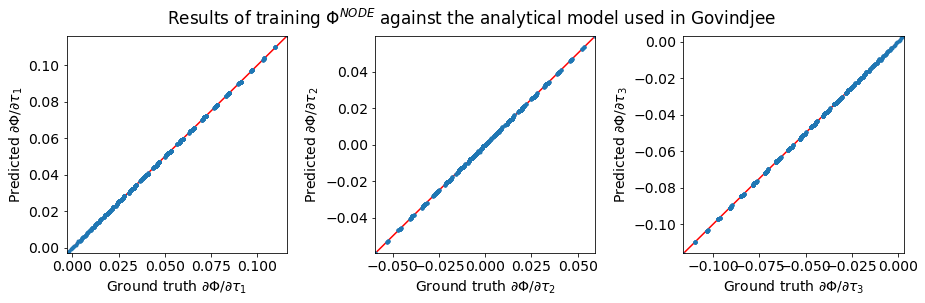

In [33]:
prs = dPhi_vmap([taui[:,0], taui[:,1], taui[:,2]], Phi_params, Phi_norm)
gts = dPhi_RG_vmap([taui[:,0], taui[:,1], taui[:,2]], eta_D, eta_V)

labels = ['$\partial \Phi / \partial \\tau_1$', '$\partial \Phi / \partial \\tau_2$', '$\partial \Phi / \partial \\tau_3$']
title = r"Results of training $\Phi^{NODE}$ against the analytical model used in Govindjee"
plot45(gts, prs, labels, title)

# 4. Test

In [3]:
#Load the pre-trained parameters
with open('saved/brain_CR_Psi_eq_params.npy', 'rb') as f:
    Psi_eq_params = pickle.load(f)
with open('saved/brain_CR_Psi_neq_params.npy', 'rb') as f:
    Psi_neq_params = pickle.load(f)
with open('saved/brain_CR_Phi_params.npy', 'rb') as f:
    Phi_params = pickle.load(f)
with open('saved/brain_CR_Phi_norm_w.npy', 'rb') as f:
    Phi_norm = pickle.load(f)
params = (Psi_eq_params, Psi_neq_params, Phi_params)
norm = (None, None, Phi_norm)

with open('saved/brain_CR_RG_params.npy', 'rb') as f:
    RG_params = pickle.load(f)

with open('training_data/Brain/Average/C1/Comp relaxation/CR.npy','rb') as f:
    time_2, sgm_x_2 = np.load(f).T
time_2 = time_2[::2]
sgm_x_2 = sgm_x_2[::2]

load_rate = 0.02 #loading rate
lm_peak = 0.9
lm_1 = np.linspace(1.0,0.9,10)
lm_2 = np.ones_like(time_2)*lm_peak
lmb_x = np.hstack([lm_1,lm_2])

t_peak = (1.0-lm_peak)/load_rate
print('Reach peak in '+str(t_peak)+' s')
time_1 = np.linspace(0,t_peak,lm_1.shape[0])
time = np.hstack([time_1, time_2+t_peak])

sgm_x_1 = np.linspace(0,sgm_x_2[0],lm_1.shape[0])
sgm_x = np.hstack([sgm_x_1, sgm_x_2])

time = np.expand_dims(time,0)
lmb_x = np.expand_dims(lmb_x,0)
sgm_x = np.expand_dims(sgm_x,0)

inp = np.array([time, lmb_x]).transpose([1,0,2])
out = sgm_x

Reach peak in 4.999999999999999 s


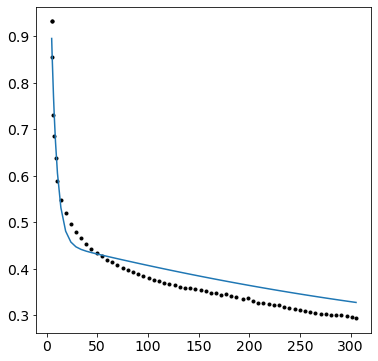

In [4]:
fig, ax = plt.subplots(figsize=(6,6))

sig_NN, lm1_NN, lm2_NN, lm3_NN, lm1e_NN, lm2e_NN, lm3e_NN  = uniaxial_relax(params, norm, True, time[0], lmb_x[0], dt0=0.1)

ax.plot(time[0,9:], sgm_x[0,9:], 'k.')
ax.plot(time[0,9:],-sig_NN[9:,0,0])

# 5. Retrain

2022-12-20 21:35:16.217362: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module jit_step.59
********************************


it 0, train loss = 1.478492e-03
it 100, train loss = 3.449846e-04
it 200, train loss = 2.981399e-04
it 300, train loss = 2.885379e-04
it 400, train loss = 2.683859e-04
it 500, train loss = 2.542032e-04
it 600, train loss = 2.352391e-04
it 700, train loss = 2.192582e-04
it 800, train loss = 2.063541e-04
it 900, train loss = 1.967078e-04
it 1000, train loss = 1.892914e-04
it 1100, train loss = 1.822685e-04
it 1200, train loss = 1.755999e-04
it 1300, train loss = 1.692877e-04
it 1400, train loss = 1.633375e-04
it 1500, train loss = 1.577509e-04
it 1600, train loss = 1.525223e-04
it 1700, train loss = 1.476289e-04
it 1800, train loss = 1.430559e-04
it 1900, train loss = 1.387945e-04
it 2000, train loss = 1.348368e-04
it 2100, train loss = 1.311617e-04
it 2200, train loss = 1.277449e-04
it 2300, train loss = 1.245635e-04
it 2400, train loss = 1.216195e-04
it 2500, train loss = 1.189305e-04
it 2600, train loss = 1.163450e-04
it 2700, train loss = 1.139727e-04
it 2800, train loss = 1.117922e-

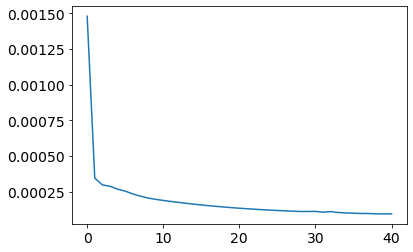

In [5]:
opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(params)

params, train_loss, val_loss = train(inp, out, norm, True, opt_state, key, uniaxial_relax_batch_loss, nIter = 4000, batch_size=1, print_freq=100)

with open('saved/brain_CR_params_retrained.npy', 'wb') as f:
    pickle.dump(params, f)

plt.plot(train_loss)

# 6. Final test

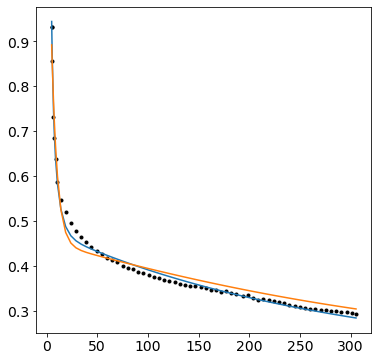

In [6]:
with open('saved/brain_CR_params_retrained.npy', 'rb') as f:
    params = pickle.load(f)
with open('saved/brain_CR_Phi_norm_w.npy', 'rb') as f:
    Phi_norm = pickle.load(f)

with open('saved/brain_CR_RG_params.npy', 'rb') as f:
    RG_params = pickle.load(f)
norm = (None, None, Phi_norm)

fig, ax = plt.subplots(figsize=(6,6))

sig_NN, lm1_NN, lm2_NN, lm3_NN, lm1e_NN, lm2e_NN, lm3e_NN  = uniaxial_relax(params, norm, True, time[0], lmb_x[0], dt0=0.1)
sig_RG, lm1_NN, lm2_NN, lm3_NN, lm1e_NN, lm2e_NN, lm3e_NN  = uniaxial_relax(RG_params, norm, False, time[0], lmb_x[0], dt0=0.1)

ax.plot(time[0,9:], sgm_x[0,9:], 'k.')
ax.plot(time[0,9:],-sig_NN[9:,0,0])
ax.plot(time[0,9:],-sig_RG[9:,0,0])

data = np.array([time[0,9:], sgm_x[0,9:], -sig_NN[9:,0,0], -sig_RG[9:,0,0]])
columns = ['x', 'y_gt', 'y_nn', 'y_rg']
df = pd.DataFrame(data.T, columns=columns)
df.to_csv('tikz_data/fig_brain/fig_brain_CR.csv', index=False, sep=' ')